In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, recall_score

from xgboost import XGBClassifier
import xgboost as xgb

In [2]:
with open("../credenciales.json", 'r') as f:
    conn_data = json.load(f)

DB_CONN = f'mysql+mysqlconnector://{conn_data["username"]}:{conn_data["password"]}@{conn_data["host"]}/{conn_data["database"]}'

## Modelo con toda la base de datos

In [3]:
SQL = """ 
SELECT
    ad.Money,
    -- ad.Interior,
    -- ad.Dimension,
    LOWER(ad.Job) AS Job,
    ad.Playtime_mins,
    ad.JailTime,
    ad.WL,
    -- DATEDIFF(CURDATE(), ad.LastOnline) AS DaysSinceLastOnline,
    ad.Kills,
    ad.Deaths,

    COALESCE(ba.Balance, 0) AS Bank_money,

    ad.vip
FROM accountdata ad
LEFT JOIN bank_accounts ba ON ad.Username = ba.Account
"""

data = pd.read_sql(SQL, DB_CONN)

data["vip"] = data["vip"].map(lambda x: False if x in ["None", "false"] else True)

In [4]:
def Preprocess_input(data):
    # PREPROCESAMIENTOS
    data.drop_duplicates(inplace=True)

    # covertir a minusculas
    str_cols = data.select_dtypes(include="object").columns
    data[str_cols] = data[str_cols].apply(lambda x: x.str.lower())

    # filtrar y convertir variable Job a si tiene o no 
    data = data[~data["Job"].isin(["0", "banned"])]

    data["Job"] = data["Job"].map(lambda x: True if x not in ["unemployed", "none"] else False)

    return data

data = Preprocess_input(data)

/tmp/ipykernel_1036/134369737.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Job"] = data["Job"].map(lambda x: True if x not in ["unemployed", "none"] else False)


In [8]:
X = data.drop(columns="vip")
y = data["vip"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [12]:
np.bincount(y_train)

array([38239,  1453])

### random forest

In [14]:
# pesos para balanceo

n_y = np.bincount(y_train)

w = n_y.max() / n_y

w = {i: w[i] for i in range(len(w))}

In [9]:
grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [7, 9, 11, 13],
    "min_samples_split": [3, 4, 5, 6, 7],
    "min_samples_leaf": [3, 4, 5, 6, 7],
}

GVmodel1 = GridSearchCV(
    RandomForestClassifier(
        random_state = 123,
        class_weight = w
    ),
    grid,
    cv=4,
    n_jobs=-1,
    verbose=3,
    scoring="recall"
)

GVmodel1.fit(X_train, y_train)

print(GVmodel1.best_params_)
print(GVmodel1.best_score_)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


[CV 1/4] END criterion=gini, max_depth=7, min_samples_leaf=3, min_samples_split=3;, score=0.469 total time=   2.2s
[CV 2/4] END criterion=gini, max_depth=7, min_samples_leaf=3, min_samples_split=3;, score=0.469 total time=   2.3s
[CV 3/4] END criterion=gini, max_depth=7, min_samples_leaf=3, min_samples_split=3;, score=0.419 total time=   2.1s
[CV 4/4] END criterion=gini, max_depth=7, min_samples_leaf=3, min_samples_split=3;, score=0.468 total time=   2.1s
[CV 1/4] END criterion=gini, max_depth=7, min_samples_leaf=3, min_samples_split=4;, score=0.469 total time=   2.1s
[CV 2/4] END criterion=gini, max_depth=7, min_samples_leaf=3, min_samples_split=4;, score=0.469 total time=   2.2s
[CV 4/4] END criterion=gini, max_depth=7, min_samples_leaf=3, min_samples_split=4;, score=0.468 total time=   2.2s
[CV 3/4] END criterion=gini, max_depth=7, min_samples_leaf=3, min_samples_split=4;, score=0.419 total time=   2.3s
[CV 2/4] END criterion=gini, max_depth=7, min_samples_leaf=3, min_samples_split=

In [10]:
pd.Series(GVmodel1.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)

Bank_money       0.316917
Playtime_mins    0.176088
Deaths           0.146715
Kills            0.143893
Money            0.112506
WL               0.060138
Job              0.027037
JailTime         0.016705
dtype: float64

In [11]:
print("PRUEBA")
print(classification_report(y_train, GVmodel1.predict(X_train)))

print("TEST")
print(classification_report(y_test, GVmodel1.predict(X_test)))

PRUEBA


              precision    recall  f1-score   support

       False       0.98      0.84      0.91     38242
        True       0.11      0.54      0.19      1439

    accuracy                           0.83     39681
   macro avg       0.55      0.69      0.55     39681
weighted avg       0.95      0.83      0.88     39681

TEST
              precision    recall  f1-score   support

       False       0.98      0.84      0.91      9563
        True       0.10      0.48      0.17       358

    accuracy                           0.83      9921
   macro avg       0.54      0.66      0.54      9921
weighted avg       0.95      0.83      0.88      9921



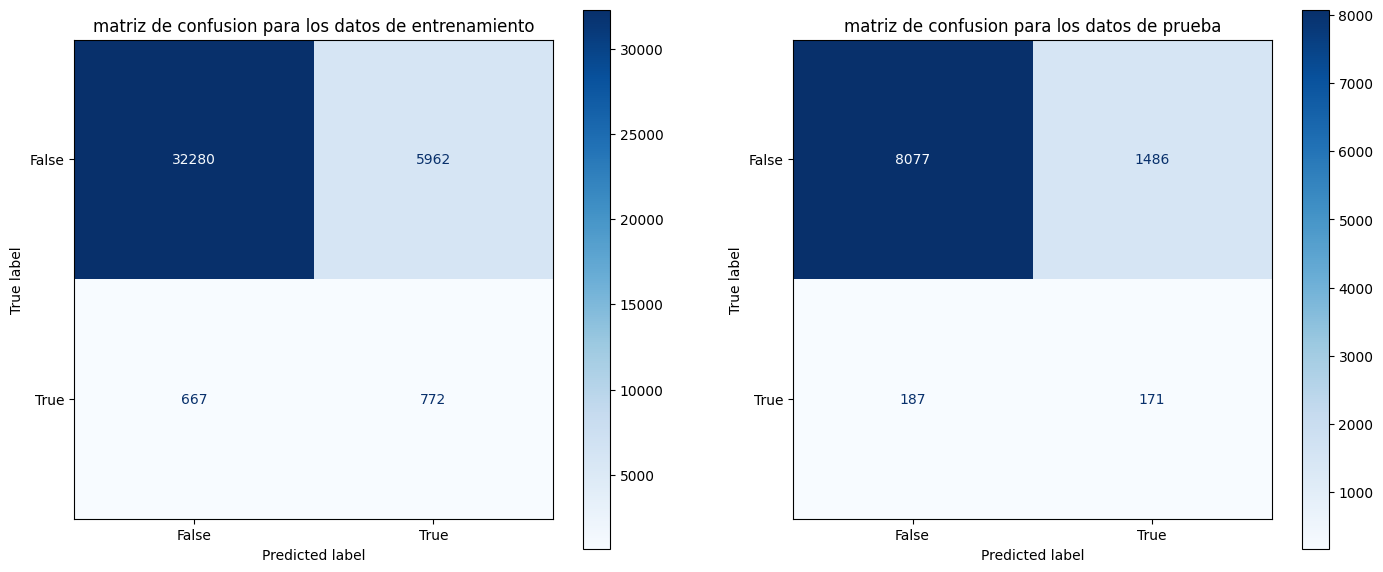

In [12]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

cmTrain = ConfusionMatrixDisplay.from_estimator(
    estimator = GVmodel1.best_estimator_,
    X = X_train,
    y = y_train,
    cmap = "Blues",
    ax = ax1,
    # normalize="true"
)

cmTest = ConfusionMatrixDisplay.from_estimator(
    estimator = GVmodel1.best_estimator_,
    X = X_test,
    y = y_test,
    cmap="Blues",
    ax = ax2,
    # normalize="true"
)

cmTrain.ax_.set_title("matriz de confusion para los datos de entrenamiento")
cmTest.ax_.set_title("matriz de confusion para los datos de prueba")

plt.show()

como era de esperarse el modelo suele no fallar en la clasificacion de los verdaderos negativos, sin embargo si tiende a dar varios falsos negativos, osea que a veces clasifica a alguien que si compro el premium como si no lo hubiera comprado

### XGBoost

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [16]:
sample_w = [w[i] for i in y_train]

In [57]:
grid = {
    "max_depth": [3,4,5,6],
    "gamma": [0, 0.1, 0.2],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': range(60, 120 + 1, 20),
}

XGBmodel = XGBClassifier( 
    objective= 'binary:logistic',
    tree_method="hist",
    random_state=123,
    n_jobs=-1,
    early_stopping_rounds=7,
    scale_pos_weight=31
)

GS_XGB_model = GridSearchCV(
    XGBmodel,
    grid,
    cv=4,
    n_jobs=-1,
    verbose=3,
    scoring="recall"
)

GS_XGB_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

Fitting 4 folds for each of 144 candidates, totalling 576 fits
[CV 2/4] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=60;, score=0.669 total time=   0.3s
[CV 1/4] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=60;, score=0.590 total time=   0.3s
[CV 4/4] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=60;, score=0.555 total time=   0.3s
[CV 3/4] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=60;, score=0.559 total time=   0.3s
[CV 3/4] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=80;, score=0.556 total time=   0.5s
[CV 2/4] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=80;, score=0.664 total time=   0.5s
[CV 4/4] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=80;, score=0.549 total time=   0.4s
[CV 1/4] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=80;, score=0.606 total time=   0.5s
[CV 1/4] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.595 total time=   0.4s
[CV 2/4] 

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=7,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=123, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': range(60, 121, 20)},
             scoring='recall', verbose=3)

In [58]:
GS_XGB_model.best_params_

{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 60}

In [59]:
print("PRUEBA")
print(classification_report(y_train, GS_XGB_model.predict(X_train)))

print("VALIDACION")
print(classification_report(y_val, GS_XGB_model.predict(X_val)))

print("TEST")
print(classification_report(y_test, GS_XGB_model.predict(X_test)))

PRUEBA
              precision    recall  f1-score   support

       False       0.98      0.70      0.82     38239
        True       0.08      0.69      0.15      1453

    accuracy                           0.70     39692
   macro avg       0.53      0.70      0.48     39692
weighted avg       0.95      0.70      0.80     39692

VALIDACION
              precision    recall  f1-score   support

       False       0.98      0.71      0.83      7650
        True       0.08      0.65      0.14       289

    accuracy                           0.71      7939
   macro avg       0.53      0.68      0.48      7939
weighted avg       0.95      0.71      0.80      7939

TEST
              precision    recall  f1-score   support

       False       0.98      0.70      0.82      9582
        True       0.07      0.59      0.12       342

    accuracy                           0.70      9924
   macro avg       0.52      0.65      0.47      9924
weighted avg       0.95      0.70      0.79      99

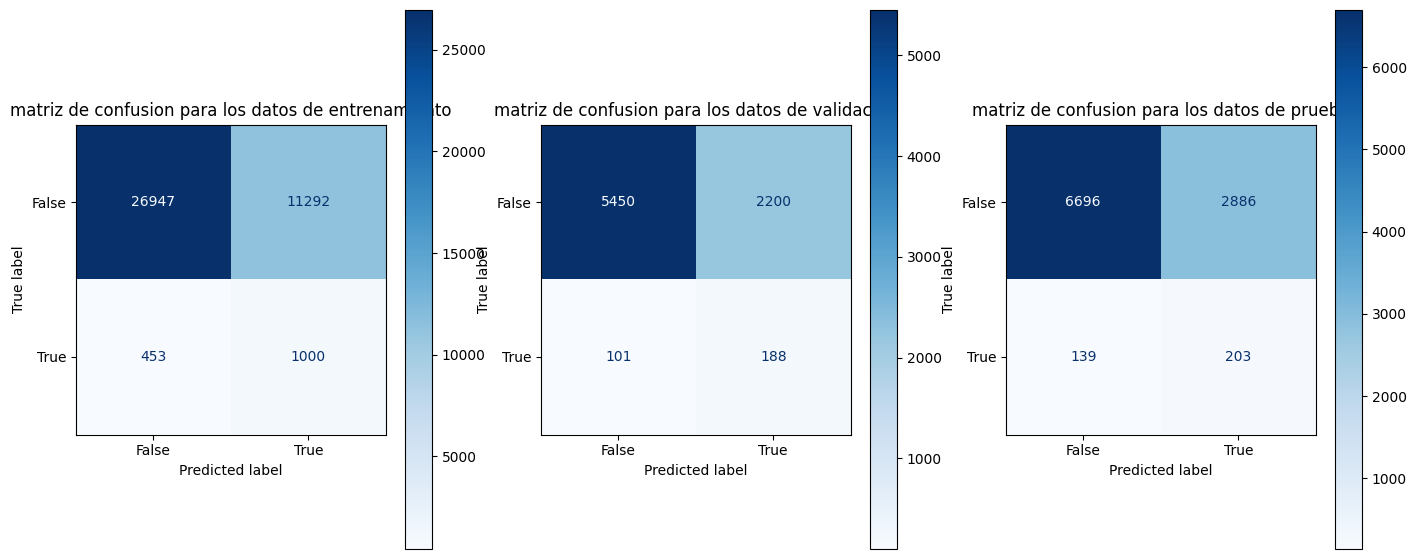

In [60]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 7))

cmTrain = ConfusionMatrixDisplay.from_estimator(
    estimator = GS_XGB_model,
    X = X_train,
    y = y_train,
    cmap = "Blues",
    ax = ax1,
    # normalize="true"
)

cmVal = ConfusionMatrixDisplay.from_estimator(
    estimator = GS_XGB_model,
    X = X_val,
    y = y_val,
    cmap = "Blues",
    ax = ax2,
    # normalize="true"
)

cmTest = ConfusionMatrixDisplay.from_estimator(
    estimator = GS_XGB_model,
    X = X_test,
    y = y_test,
    cmap="Blues",
    ax = ax3,
    # normalize="true"
)

cmTrain.ax_.set_title("matriz de confusion para los datos de entrenamiento")
cmVal.ax_.set_title("matriz de confusion para los datos de validacion")
cmTest.ax_.set_title("matriz de confusion para los datos de prueba")

plt.show()

In [62]:
GS_XGB_model.best_estimator_.save_model("../model.json")